<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/09_%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2_(CNN_YOLO_v3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Обнаружение объектов (CNN YOLO v3)**

# 1 Постановка задачи

*1. Обернуть в функцию разобранные на лекции этапы распознавания изображения. На вход должно подаваться исходное изображение. На выходе должно быть исходное изображение со всеми найденными bounding_box.*

*2. Проверить гипотезы:*

*2.1 Необходимо провести обучение модели (YOLOv3 или RetinaNet) на уменьшенной выборке (взять неполную базу самолетов из 1000 элементов, а 50-100 элементов). Проанализировать изменение ошибки и оценить насколько эти данные коррелируются с ошибкой на полной базе. Оценить на сколько снизилось время обучения.*

*2.2 В случае успешного подтверждения теории (то есть падение ошибки на уменьшенной базе соответствует падению ошибки на полной базе): добиться минимального значения ошибки на неполной базе. Провести обучение сети на измененных данных для полной базы (200-300 эпох) и проверить результаты.*

# 2 Подгрузка библиотек и подключение диска

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ZeroPadding2D, Add, UpSampling2D, Concatenate, Lambda, LeakyReLU # Стандартные слои Keras
from tensorflow.keras.regularizers import l2 # Регуляризатор l2
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam
from tensorflow.keras.models import Model # Абстрактный класс Model
from PIL import Image, ImageDraw, ImageFont # Модули работы с изображениями
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb # Модули конвертации между RGB и HSV
from google.colab import files # Модуль работы с файловой системой google

import tensorflow.keras.backend as K # бэкенд Keras
import math # Импортируем модуль math
import pandas as pd # Пандас для работы с csv
import tensorflow as tf # TensorFlow
import numpy as np # numpy массивы
import matplotlib.pyplot as plt # графики
import os # модуль работы с файловой системой
import time # модуль работы со временем

In [ ]:
from google.colab import drive # подключаем гугл драйв диск для загрузки файлов
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Глобальные параметры

In [ ]:
path = '/content/drive/My Drive/HW_31/Самолётики/' # Путь к директории на диске, где находятся изображения
name_classes = ['Самолеты'] # Названия классов
num_classes = len(name_classes) # Количество классов
input_shape = (416, 416) # Размерность входного изображения для модели YOLO

# Массив используемых анкоров (в пикселях). Используетя по 3 анкора на каждый из 3 уровней сеток
# данные значения коррелируются с размерностью входного изображения input_shape
anchors = np.array([[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]])
num_anchors = len(anchors) # Сохраняем количество анкоров

# 4 Создание модели

## 4.1 Функции

In [ ]:
'''
    Функция создания полной модели
        Входные параметры:
          input_shape - размерность входного изображения для модели YOLO
          num_anchors - общее количество анкоров
          use_weights - использовать ли предобученные веса
          weights_path - путь к сохраненным весам модели
'''
def create_model(
        input_shape,
        num_anchors,
        use_weights = False,
        weights_path = 'yolo.h5'
        ):
    w, h = input_shape # Получаем ширину и высоту входного изображения
    inputs = Input(shape = (w, h, 3)) # Создаем входной слой модели, добавляя размерность для глубины цвета

    # Создаем три входных слоя y_true с размерностями ((None, 13, 13, 3, 6), (None, 26, 26, 3, 6) и (None, 52, 52, 3, 6))
    # 2 и 3 параметры (13, 13) указывают размерность сетки, на которую условно будет разбито исходное изображение
    # каждый уровень сетки отвечает за обнаружение объектов различных размеров (13 - крупных, 26 - средних, 52 - мелких)
    # 4 параметр - количество анкоров на каждый уровень сетки
    # 5 параметр - 4 параметра описывающие параметры анкора (координаты центра, ширина и высота) + вероятность обнаружения объекта + OHE номер класса
    y_true = [Input (shape = (w // 32, h // 32, num_anchors // 3, num_classes + 5))] # Уровень сетки 13х13 (416/32)
    y_true.append (Input (shape = (w // 16, h // 16, num_anchors // 3, num_classes + 5))) # Уровень сетки 26х26 (416/26)
    y_true.append (Input (shape = (w // 8, h // 8, num_anchors // 3, num_classes + 5))) # Уровень сетки 52х52 (416/8)

    model_yolo = create_YOLOv3(inputs, num_anchors // 3) # Создаем модель YOLOv3
    print ('Создана модель YOLOv3. Количество классов: {}.'.format(num_classes)) # Выводим сообщение о создании модели

    # Если установлен флаг загрузки весов
    if use_weights:
        model_yolo.load_weights(weights_path, by_name = False, skip_mismatch = False) # Загружаем предобученные веса
        print ('Загружены веса из файла {}.'.format(weights_path)) # Выводим сообщение о загруженных весах

    # Создаем выходной слой Lambda (выходом которого будет значение ошибки модели)
    # На вход слоя подается:
    #   - model_yolo.output (выход модели model_yolo (то есть то, что посчитала сеть))
    #   - y_true (оригинальные данные из обучающей выборки)
    outputs = Lambda(yolo_loss, output_shape = (1,), name = 'yolo_loss', arguments = {'num_anchors' : num_anchors}) ([*model_yolo.output, *y_true])

    return Model([inputs, *y_true], outputs) # Возвращаем модель

In [ ]:
'''
Функция создания модели YOLOv3
    Входные параметры:
          inputs - Входной слой модели
          num_sub_anchors - количество анкоров в каждом уровне сеток
'''
def create_YOLOv3(
        inputs,
        num_sub_anchors
        ):
    #--------------------
    # Базовая часть модели YOLOv3
    #--------------------

    # Состоит из Conv2D-слоев и Residual-блоков. Residual-блок - это блок использующий информацию из предыдущих слоев.
    # С помощью слоя Add (Суммируется текущий слой и один из предыдущих), что позволяет избежать проблему потери информации
    # Количество resedual блоков и архитектура сети взята из документации YOLOv3
    x = ConvBL (inputs, 32, (3, 3)) # Добавляем каскад из трех слоев (Conv2D, BatchNormalization и Leaky)
    x = resblock (x, 64, 1) # Добавляем 1 resedual-блок с 64 нейронами
    x = resblock (x, 128, 2) # Добавляем 2 resedual-блока с 128 нейронами
    x = resblock (x, 256, 8) # Добавляем 8 resedual-блоков с 256 нейронами
    x = resblock (x, 512, 8) # Добавляем 8 resedual-блоков с 512 нейронами
    x = resblock (x, 1024, 4) # Добавляем 4 resedual-блоков с 1024 нейронами
    base_model = Model(inputs, x) # Создаем базовую часть модели YOLOv3

    #--------------------
    # Detection часть модели YOLOv3
    #--------------------

    # Выделяем три выхода сети, соответсвующих различным уровням сетки


    # 13 x 13 (обнаружение больших объектов)
    x = ConvBL(base_model.output, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))
    x = ConvBL(x, 1024, (3, 3))
    x = ConvBL(x, 512, (1, 1))

    # Выделяем первый выход модели, соответствующий размерности 13 х 13
    y1 = ConvBL(x, 1024, (3,3))
    y1 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y1)


    # 26x26 (обнаружение средних объектов)

    # Размерность текущего выхода сети равна 13 х 13. Необходимо увеличить ее до 26 x 26 и
    # объеденить со 152-ым слоем (размерностью 26 x 26)
    x = ConvBL(x, 256, ( 1, 1))
    x = UpSampling2D(2) (x) # Увеличиваем размерность до 26 на 26, использую UpSampling
    x = Concatenate()([x,base_model.layers[152].output])

    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))
    x = ConvBL(x, 512, (3, 3))
    x = ConvBL(x, 256, (1, 1))

    # Выделяем второй выход модели, соответствующий размерности 26 х 26
    y2 = ConvBL(x, 512, (3, 3))
    y2 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y2)

    # 52 x 52 (обнаружение маленьких объектов)

    # Размерность текущего выхода сети равна 26 х 26. Необходимо увеличить ее до 52 x 52 и
    # объеденить со 92-ым слоем (размерностью 52 x 52)
    x = ConvBL(x, 128, ( 1, 1))
    x = UpSampling2D(2) (x)  # Увеличиваем размерность до 52 на 52, использую UpSampling
    x = Concatenate()([x,base_model.layers[92].output])

    # Добавляем 5 блоков ConvBL
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))
    x = ConvBL(x, 256, (3, 3))
    x = ConvBL(x, 128, (1, 1))

    # Выделяем третий выход модели, соответствующий размерности 52 х 52
    y3 = ConvBL(x, 256, (3, 3))
    y3 = Conv2D(num_sub_anchors * (num_classes + 5), (1, 1), padding = 'same', kernel_regularizer = l2(5e-4)) (y3)

    return Model(inputs, [y1, y2, y3]) # Возвращаем модель

In [ ]:
''' Функция создания Residual блока.
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          num_filters - количество нейронов
          num_blocks  - количество блоков
 '''
def resblock(
        inputs,
        num_filters,
        num_blocks
        ):
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs) # Увеличиваем размерность на один шаг влево и вверх
    x = ConvBL(x, num_filters, (3, 3), strides=(2, 2)) # Добавляем блок ConvBL
    for i in range(num_blocks): # Пробегаем в цикле num_blocks-раз (суммируя слои с помощью Add())
        y = ConvBL(x, num_filters // 2, (1, 1))
        y = ConvBL(y, num_filters, (3, 3))
        x = Add() ([x, y])
    return x # Возвращаем слой

In [ ]:
''' Функция создания блока Conv2D, BatchNormalization, LeakyRelu
    Входные параметры:
          inputs - Стартовый слой, к которому добавляется Res-блок
          args - массив неименованных параметров
          kwargs  - массив именованных параметров
 '''
def ConvBL(
        inputs,
        *args,
        **kwargs
        ):
    new_kwargs = {'use_bias': False} # создаем новый массив именованных параметров, добавляя параметр use_bias
    new_kwargs['kernel_regularizer'] = l2(5e-4) # добавляем параметр kernel_regularizerpadding
    new_kwargs['padding'] = 'valid' if kwargs.get('strides') == (2, 2) else 'same' # добавляем параметр  padding
    new_kwargs.update(kwargs) # Добавляем уже имеющиеся в kwargs gfhfvtnhs
    x = Conv2D(*args, **new_kwargs) (inputs) # Добавляем Conv2D слой
    x = BatchNormalization() (x) # Добавляем слой BatchNormalization
    x = LeakyReLU(alpha=0.1) (x) # Добавляем слой LeakyRelu
    return x

In [ ]:
'''
Функция подсчета ошибки.
    Входные параметры:
        inputs - Входные данные
        num_anchors - общее количество анкоров
'''
def yolo_loss(
      inputs,
      num_anchors
      ):
    ignore_thresh = .5 # Порог вероятности обнаружения объекта
    num_layers = num_anchors // 3 # Подсчитываем количество анкоров на каждом уровне сетки
    y_pred = inputs[:num_layers] # Из входных данных выцепляем посчитанные моделью значения
    y_true = inputs[num_layers:] # Из входных данных выцепляем эталонные значения
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]] # Задаем маску анкоров для каждого уровня сеток


    # Получаем размерность входного изображения ( (13 х 13) * 32 = (416 х 416)) и приводим к типу элемента y_true[0]
    input_shape = K.cast(K.shape(y_pred[0])[1:3] * 32, K.dtype(y_true[0]))

    # Получаем двумерный массив, соответствующий размерностям сеток ((13, 13), (26, 26), (52, 52))
    grid_shapes = [K.cast(K.shape(y_pred[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]

    loss = 0 # Значение ошибки

    # Считываем количество элементов
    m = K.shape(y_pred[0])[0] # Размер пакета
    batch_size = K.cast(m, K.dtype(y_pred[0])) # Преобразуем к типу y_pred[0]

    for l in range(num_layers): # Пробегаем по всем трем уровням сеток
        # Получаем маску для сетки l-го уровня по вероятности определения объекта (5-ый параметр в списке общих параметров).
        # В массиве object_mask будут значения, которые соответствуют только вероятности обнаружения объекта
        object_mask = y_true[l][..., 4:5] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])

        # Получаем аналогичную выборку для сетки l-го уровня с OHE (где записана позиция нашего класса)
        # В массиве true_class будут значения, которые соответсвуют только OHE представлению класса ядля данного уровня анкоров
        true_class = y_true[l][..., 5:] # Вернется набор данных вида: ([0][0][0][0]...[1]...[0])

        num_sub_anchors = len(anchors[anchor_mask[l]]) # Получаем количество анкоров для отдельного уровян сетки (3)

        # Решейпим анкоры отдельного уровня сетки и записываем в переменную anchors_tensor
        anchors_tensor = K.reshape(K.constant(anchors[anchor_mask[l]]), [1, 1, 1, num_sub_anchors, 2])

        # Создаем двумерный массив grid со значениями [[[0, 0] , [0, 1] , [0, 2] , ... , [0, k]],
        #                                             [[1, 0] , [1, 1] , [1, 2] , ... , [1 ,k]],
        #                                             ...
        #                                             [[k, 0] , [k, 1] , [k, 2] , ... , [k, k]]]
        # где k - размерность сетки. Массив хранит индексы ячеек сетки
        grid_shape = K.shape(y_pred[l])[1:3] # Получаем ширину и высоту сетки
        grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),[1, grid_shape[1], 1, 1]) # Создаем вертикальную линию
        grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),[grid_shape[0], 1, 1, 1]) # Создаем горизонтальную линию
        grid = K.concatenate([grid_x, grid_y]) # Объединяем
        grid = K.cast(grid, K.dtype(y_pred[l])) # Приводим к типу y_pred[l]

        # Решейпим y_pred[l]
        feats = K.reshape(y_pred[l], [-1, grid_shape[0], grid_shape[1], num_sub_anchors, num_classes + 5])

        # Считаем ошибку в определении координат центра объекта
        # Получаем координаты центра объекта из спредиктенного значения
        pred_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
        # Производим обратные вычесления для оригинальных значений из y_true для координат центра объекта
        true_xy = y_true[l][..., :2] * grid_shapes[l][::-1] - grid  # Реальные координаты центра bounding_box
        box_loss_scale = 2 - y_true[l][...,2:3] * y_true[l][...,3:4] # чем больше бокс, тем меньше ошибка
        # binary_crossentropy для истинного значения и спредиктенного (obect_mask для подсчета только требуемого значения)
        xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(true_xy, feats[...,0:2], from_logits=True)

        # Считаем ошибку в определении координат ширины и высоты
        # Получаем значения ширины и высоты изображения из спредиктенного значения
        pred_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
        # Производим обратные вычесления для оригинальных значений из y_true для ширины и высоты объекта
        true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
        # Оставляем значение высоты и ширины только у тех элементов, где object_mask = 1
        true_wh = K.switch(object_mask, true_wh, K.zeros_like(true_wh))
        # Считаем значение ошибки в определении высоты и ширины
        wh_loss = object_mask * box_loss_scale * 0.5 * K.square(true_wh-feats[...,2:4])

        # Объединяем значения в один  массив
        pred_box = K.concatenate([pred_xy, pred_wh])

        # Считаем ошибку в определении обнаружения какого-либо класса
        # Для этого вначале надо отсечь все найденные объекты, вероятность которых меньше установленного значения ignore_thresh

        # Определяем массив, который будет хранить данные о неподходящих значениях
        ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
        object_mask_bool = K.cast(object_mask, 'bool') # Приводим тип object_mask к типу 'bool'

        # Функция, определяющая данные, которые требуется игнорировать
        # Пробегаем по всем элементам пакета (b<m)
        # Получаем параметры реального bounding_box для текущей ячейки
        # Считаем IoU реального и спредиктенного
        # В зависимости от best_iou < ignore_thresh помечаем его как верно распознанный или неверено
        def loop_body(
                b,
                ignore_mask
                ):
            # в true_box запишутся первыые 4 параметра (центр, высота и ширина объекта) того элемента, значение которого в object_mask_bool равно True
            true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
            # Подсчитываем iou для спредиктенной ограничивающей рамки (pred_box) и оригинальной (true_box)
            iou = calc_iou(pred_box[b], true_box)
            # Находим лучшую ограничивающую рамку
            best_iou = K.max(iou, axis=-1)
            # Записываем в ignore_mask true или false в зависимости от (best_iou < ignore_thresh)
            ignore_mask = ignore_mask.write(b, K.cast(best_iou < ignore_thresh, K.dtype(true_box)))
            return b+1, ignore_mask # Увеличиваем счетчик на еденицу и возвращаем ignore_mask

        # Пробегаем в цикле по всем элементам в пределах значения m (m = batch size)
        _, ignore_mask = tf.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
        ignore_mask = ignore_mask.stack() # Приводим ignore_mask к тензору
        ignore_mask = K.expand_dims(ignore_mask, -1) # Добавляем еще одну размерность в конце ignore_mask

        # Считаем значение ошибки
        # 1 компонента - для значений, которые были верно спредиктены
        # 2 компонентя - для значения, которые были неверно спредиктены
        confidence_loss = (
            object_mask * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) +
            (1-object_mask) * K.binary_crossentropy(object_mask, feats[...,4:5], from_logits=True) * ignore_mask
            )

        # Считаем ошибку в определении класса объекта
        class_loss = object_mask * K.binary_crossentropy(true_class, feats[...,5:], from_logits=True)

        # Считаем суммарную ошибку
        xy_loss = K.sum(xy_loss) / batch_size
        wh_loss = K.sum(wh_loss) / batch_size
        confidence_loss = K.sum(confidence_loss) / batch_size
        class_loss = K.sum(class_loss) / batch_size
        loss += xy_loss + wh_loss + confidence_loss + class_loss

    return loss # Возвращаем значение ошибки

In [ ]:
'''
    Функция подсчета IoU
'''
def calc_iou(input1, input2):
    input1 = K.expand_dims(input1, -2) # Добавляем одну размерность
    xy1 = input1[..., :2] # Получаем координаты x,y центра
    wh1 = input1[..., 2:4] # Получаем значения высоты и ширины
    wh_half1 = wh1 / 2. # Делим значения высоты и ширины пополам
    top_left1 = xy1 - wh_half1 # Получаем значение, соответствующее верхнему левому углу
    right_bottom1 = xy1 + wh_half1 # Получаем значение, соотвествующее правому нижнему углу

    input2 = K.expand_dims(input2, 0) # Добавляем одну размерность
    xy2 = input2[..., :2] # Получаем координаты x,y центра
    wh2 = input2[..., 2:4] # Получаем значения высоты и ширины
    wh_half2 = wh2 / 2. # Делим значения высоты и ширины пополам
    top_left2 = xy2 - wh_half2 # Получаем значение, соответствующее верхнему левому углу
    right_bottom2 = xy2 + wh_half2 # Получаем значение, соотвествующее правому нижнему углу

    intersect_mins = K.maximum(top_left1, top_left2) # Берем максимальные координаты из левых верхних углов
    intersect_maxes = K.minimum(right_bottom1, right_bottom2) # Берем Минимальные координаты координаты из правых нижних углов
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # Считаем ширину и высоту области пересечения
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # Считаем площадь области пересечения

    area1 = wh1[..., 0] * wh1[..., 1] # Считаем площадь первых элементов
    area2 = wh2[..., 0] * wh2[..., 1] # Считаем площадь вторых элементов

    return intersect_area / (area1 + area2 - intersect_area) # Возвращаем IoU


## 4.2 Основной код

In [ ]:
# Создаем модель
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path='/content/drive/My Drive/HW_31/YOLOv3__el1000__opt0.0001__ep0_100.h5')

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/HW_31/YOLOv3__el1000__opt0.0001__ep0_100.h5.


In [ ]:
# Выводим входные размерности для модели
model_YOLO.input

[<KerasTensor: shape=(None, 416, 416, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 13, 13, 3, 6) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 26, 26, 3, 6) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 52, 52, 3, 6) dtype=float32 (created by layer 'input_4')>]

In [ ]:
# Выводим выходныую размерность модели
model_YOLO.output

<KerasTensor: shape=() dtype=float32 (created by layer 'yolo_loss')>

In [ ]:
# Выводим информацию о модели
model_YOLO.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 416, 416, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

## 4.3 Обучение модели

### 4.3.1 Просмотр данных для обучения

На вход модели подается 2 параметра: 1. numpy-массив размерностью (416,416,3), соответствующий исходному изображению 2. трехмерный массив y_true, в котором записана информация об анкоре, описывающем наш объект размерность первого элемента массива (13,13,3,6) - 13на13 - размер сетки, 3 - количество анкоров для каждой ячейки сетки, 6 - параметры анкора размерность второго элемента массива (26,26,3,6) размерность третьего элемента массива (52,52,3,6)

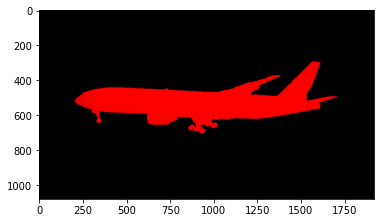

In [ ]:
# Открываем файл сегментированной модели
filename = 'airplane_50' # Имя файла
image = Image.open('/content/drive/My Drive/HW_31/Самолётики/Segment/'+filename+'.jpg') # Загружаем изображение сегментированной модели
img1 = ImageDraw.Draw(image) # Создаем экземпляр изображения
plt.imshow(image) # Рисуем изображение

minX = 202    minY = 293    maxX = 1711    maxY = 706


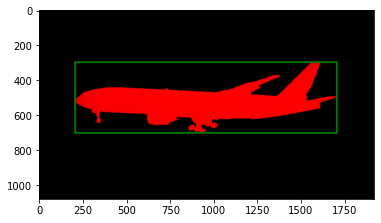

In [ ]:
# Находим координаты ограничивающего бокса (ищем по красному параметру в массиве RGB)
image_n = np.array(image) # Переводим в numpy
image_red = image_n[:,:,0] # Оставляем только красный цвет
itemindex = np.array(np.where(image_red > 20 )) # Ищем все элементы, в которых значение красного цвета больше 20
# np.where веренет двумерный кортеж, где первый элемент соответсвует найденным строкам, второй - найженным столбцам
minY = min (itemindex[0]) # minY будет соответствовать минимальному значению в первом элементе itemindex
maxY = max (itemindex[0]) # maxY будет соответствовать максимальному значению в первом элементе itemindex
minX = min (itemindex[1]) # minX будет соответствовать минимальному значению во втором элементе itemindex
maxX = max (itemindex[1]) # maxX будет соответствовать максимальному значению во втором элементе itemindex
print ('minX = ',minX, '    minY = ', minY, '    maxX = ', maxX, '    maxY = ',maxY, sep='') # Выводим найденные значения

# Рисуем ограничивающую рамку
for i in range(10):
  img1.rectangle([minX+i,minY+i,maxX-i,maxY-i], outline = 'green')
plt.imshow(image)

In [ ]:
# Запишем всю информацию об объекте в словарь
dictionary = {} # Создаем словарь
class_id = 0 # Номер класса. У нас всего один класс
key = filename # Значение ключа соответсвует имени модели
dictionary[key] = 'Самолеты/'+key+'.jpg'+' '+str(minX)+','+str(minY)+','+str(maxX)+','+str(maxY)+','+str(class_id) # Записываем
      # информацию об изображении: Имя_файла minX,minY,maxX,maxY,class_id
print (dictionary) # Выводим словарь

{'airplane_50': 'Самолеты/airplane_50.jpg 202,293,1711,706,0'}


Размер исходного изображения:  1920 1080
Размерность входных данных для модели: 416 416
Параметры ограничивающей рамки [[ 202  293 1711  706    0]]


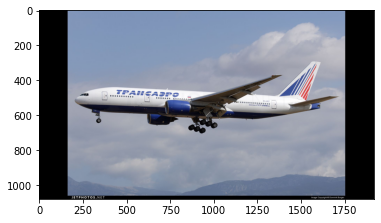

In [ ]:
# Загружаем оригинальное изображение
line = dictionary[filename].split() # Сплитим по пробелу значение в словаре: 'Air/airplane_10.jpg 332,360,1661,736,0'
image = Image.open(path+line[0]) # Загружаем файл изображения
iw, ih = image.size # Запоминаем оригинальные размеры изображения
w, h = (416,416) # Устанавливаем ширину и высоту изображения для модели YOLO
box = np.array([np.array(list(map(lambda x: int((float)(x)),box.split(',')))) for box in line[1:]]) # Получаем список параметров для ограничивающих рамом для всех объектов
                                                                                            # на изображении. В нашем случае будет всего одна ограничивающая рамка
plt.imshow(image)   # рисуем изображение
print ('Размер исходного изображения: ',iw, ih) # Выводим размер исходного изображения
print ('Размерность входных данных для модели:', h, w) # Выводим размеры изображения для входного слоя модели YOLO
print ('Параметры ограничивающей рамки', box) # Выводим параметры ограничивающей рамки

Коэффициент масштабирования:  1.4727556082705229
Новый размер изображения:  612 575


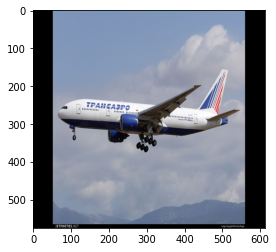

In [ ]:
# Аугментация изображения

# Функция получения случайного числа
def rand(a = 0, b = 1):
  return np.random.rand() * (b - a) + a

# -----
# Параметры для аугментации изображения
# -----
jitter = .3
hue = .1
sat = 1.5
val = 1.5

# Масштабируем изображение
new_ar = w / h * rand(1 - jitter, 1 + jitter) / rand(1 - jitter, 1 + jitter)
scale = rand(.65, 2)
print ('Коэффициент масштабирования: ', scale)
# Масштабируем изображение
if new_ar < 1:
    nh = int(scale * h)
    nw = int(nh * new_ar)
else:
    nw = int(scale * w)
    nh = int(nw / new_ar)
print ('Новый размер изображения: ',nw, nh)
image1 = image.resize((nw,nh), Image.BICUBIC) # Изменяем размер исходного изображения
plt.imshow(image1) # Рисуем изображение

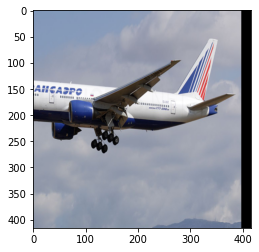

In [ ]:
# Приводим к размеру 416 на 416 пикселей для модели YOLO и размещаем в случайном месте на изображении
dx = int(rand(0, w - nw))
dy = int(rand(0, h - nh))
new_image = Image.new('RGB', (w, h), (128,128,128))
new_image.paste(image1, (dx, dy))
image2 = new_image
plt.imshow(image2)

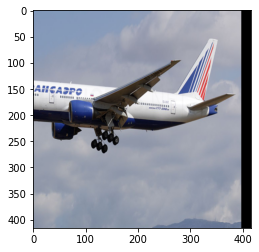

In [ ]:
# Случаным образом отображаем изображение по горизонтале
flip = rand() < .5 # с вероятностью 50% получаем параметр отражения картинки
if flip:
    image2 = image2.transpose(Image.FLIP_LEFT_RIGHT) # Если требуется, то отражаем картику по горизонтале
plt.imshow(image2) # Рисуем картинку

(416, 416, 3)


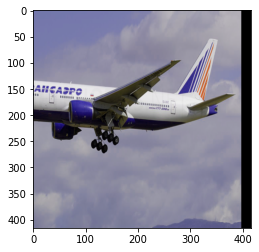

In [ ]:
# Случайным образом меняем освещенность, экспозицию, гамму изображения
hue1 = rand(-hue, hue)
sat1 = rand(1, sat) if rand() < .5 else 1 / rand(1, sat)
val1 = rand(1, val) if rand() < .5 else 1 / rand(1, val)
x = rgb_to_hsv(np.array(image2) / 255.)
x[..., 0] += hue1
x[..., 0][x[..., 0] > 1] -= 1
x[..., 0][x[..., 0] < 0] += 1
x[..., 1] *= sat1
x[..., 2] *= val1
x[x > 1] = 1
x[x < 0] = 0
image_data = hsv_to_rgb(x) # numpy array, 0 to 1
print (image_data.shape) # Входные данные для модели YOLO, соответствующие изображению, размерностью 416х416х3
plt.imshow(image_data) # Рисуем изображение

[  0.  53. 383. 273.   0.]


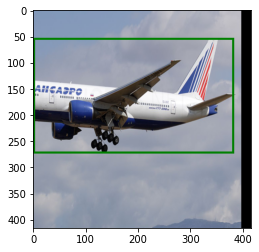

In [ ]:
# Корректируем параметры ограничивающей рамки
max_boxes = 5 # Устанавливаем максимальное кличество ограничивающих рамок
box_data = np.zeros((max_boxes,5)) # Массив будет хранить параметры ограничивающих рамок. Всего 5 параметров. Первые 4 - координаты minX, minY, maxX, maxY. 5-ый  - номер класса объекта ( в нашем случае всего один класс - самолеты)

box_mod = box.copy()
# Проходим те же модификации с ограничивающей рамкой, что и с изображением: масштабирование, отраженгие
box_mod[:, [0,2]] = box_mod[:, [0,2]] * nw / iw + dx
box_mod[:, [1,3]] = box_mod[:, [1,3]] * nh / ih + dy
if flip:
    box_mod[:, [0,2]] = w - box_mod[:, [2,0]]
box_mod[:, 0:2][box_mod[:, 0:2] < 0] = 0
box_mod[:, 2][box_mod[:, 2] > w] = w # Если выходит за ширину
box_mod[:, 3][box_mod[:, 3] > h] = h # Если выходит за высотц
box_w = box_mod[:, 2] - box_mod[:, 0]
box_h = box_mod[:, 3] - box_mod[:, 1]
box_mod = box_mod[np.logical_and(box_w > 1, box_h > 1)] # Отсекаем маленькие рамки

if len(box_mod) > max_boxes:
    box_mod = box_mod[:max_boxes] # Если количество ограничивающих рамок больше установленного нами ранее
box_data[:len(box_mod)] = box_mod # Записываем в box_data информацию об ограничивающих рамках аугментированного изображения
print(box_data[0]) # Выводим параметры рамки для аугментированного изображения
img1 = ImageDraw.Draw(image2) # Создаем экземпляр изображения
for i in range(4): # Рисуем ограничивающую рамку
    img1.rectangle([box_data[0][0] + i, box_data[0][1] + i, box_data[0][2] - i, box_data[0][3] - i], outline = 'green')
plt.imshow(image2)

In [ ]:
num_layers = 3 # Количество анкоров на каждую сетку (в нашем случае каждая сетка будет иметь анкоры 3 разных размеров)
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Маска дял выбора анкоров

real_boxes = np.array(box_data, dtype='float32') # Переводим в numpy
input_shape = np.array((416,416), dtype='int32') # Переводим в numpy

# Определяем центр ограничивающей рамки и ее ширину и высоту
boxes_xy = (real_boxes[:,0:2] + real_boxes[:,2:4]) // 2
boxes_wh = real_boxes[..., 2:4] - real_boxes[..., 0:2]

print('Центр ограничивающей рамки: ', boxes_xy[0])
print('Ширина и высота ограничивающей рамки:', boxes_wh[0])

Центр ограничивающей рамки:  [191. 163.]
Ширина и высота ограничивающей рамки: [383. 220.]


In [ ]:
# Переводим параметры ограничивающей рамки в относительные координаты (от 0 до 1)
real_boxes[:, 0:2] = boxes_xy/input_shape[0]
real_boxes[:, 2:4] = boxes_wh/input_shape[1]
print(real_boxes[0])  # Первые два элемента - центр ограничивабщей рамки в относительных координатах,
                      # Вторые два элемента - ширина и высотка ограничивающей рамки в относительных размерах
                      # Пятый элемент - класс объекта

[0.4591346  0.39182693 0.9206731  0.52884614 0.        ]


In [ ]:
# Создадим заготовку под входные слои y_true
cells = [13,26,52]
y_true = [np.zeros((cells[l],cells[l],len(anchor_mask[l]),5+num_classes),dtype='float32') for l in range(num_layers)]
print(y_true[0].shape)
print(y_true[1].shape)
print(y_true[2].shape)
# Таким образом получаем массив из трех сеток разных размеров (13х13, 26х26, 52х52), где каждая ячейка содержит
# три варинта пар анкоров и 5+1 параметр описания каждой из пар анкоров

(13, 13, 3, 6)
(26, 26, 3, 6)
(52, 52, 3, 6)


In [ ]:
# из 9 анкоров фиксированного размера требуется найти тот, котоырй максимально охватывает ограничивающую рамку
# для этого пробегаем по всем имеющимся анкорам и считаем IoU всех вариантов

# Площадь, занятая ограничивающей рамкой
wh = boxes_wh[0, :] # Получаем ширину и высоту
box_area = wh[0] * wh[1] # Считаем площадь рамки
print (wh[0],'*',wh[1],'=', box_area)

383.0 * 220.0 = 84260.0


In [ ]:
# Площади, которые занимаю анкоры
anchor_area = anchors[:, 0] * anchors[:, 1]
print (anchor_area)

[   130    480    759   1830   2790   7021  10440  30888 121598]


In [ ]:
# Получим новые параметры анкоров, значения которых не превышают значения высоты и ширины ограничивающей рамки
correct_anchors = []
for elem in anchors:
    correct_anchors.append ([min(elem[0], wh[0]), min(elem[1], wh[1])])
correct_anchors = np.array(correct_anchors)
print(correct_anchors)
# Площади, которые занимаю скорректированные анкоры
correct_anchors_area = correct_anchors[:,0] * correct_anchors[:,1]
print(correct_anchors_area)


[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 198.]
 [373. 220.]]
[  130.   480.   759.  1830.  2790.  7021. 10440. 30888. 82060.]


In [ ]:
# Подсчитвываем iou всех вариантов
iou = correct_anchors_area / (box_area + anchor_area - correct_anchors_area)
print(iou)

[0.00154284 0.00569665 0.00900783 0.02171849 0.0331118  0.08332542
 0.12390221 0.36657963 0.662854  ]


In [ ]:
# Определяем позицию лучшего анкора
best_anchor = np.argmax(iou, axis=-1)
print (best_anchor)

8


In [ ]:
print('Параметры ограничивающей рамки',real_boxes[0])
for l in range(num_layers): # Пробегаем по всем 3 уровням анкорв
    if best_anchor in anchor_mask[l]: # Если лучший анкор есть в l-ом элементе маски анкоров
        print('Уровень анкора =',l)
        i = np.floor(real_boxes[0,0]*cells[l]).astype('int32') # Определяем позицию ячейки по горизонтале
        print ('i =',i)
        j = np.floor(real_boxes[0,1]*cells[l]).astype('int32') # Определяем позицию ячейки по вертикале
        print ('j =',j)
        k = anchor_mask[l].index(best_anchor) # Определяем номре анкора в маске анкоров
        print('Номер поданкора =',k)
        c = real_boxes[0, 4].astype('int32') # Записываем номер класса объекта
        print ('Номер класса =',c)
        y_true[l][j, i, k, 0:4] = real_boxes[0, 0:4] # Записываем 4 параметра объекта - координаты центра, ширина и высота
        y_true[l][j, i, k, 4] = 1 # Записываем вероятность того, что найден объект (для обучающей выборки всегда 1)
        y_true[l][j, i, k, 5+c] = 1  # В позицию 5+с записываем класс объекта (ohe)
        break

print(y_true[l][j,i,...])
# Таким образом массив y_true состоит полностью из 0 и только в 0-ом элементе, который соответсвует сетке, разбиением 13 на 13,
# в ячейке (6,6), которая соответствует позиции центра ограничивающей рамки (0.5, 0.4903846) в позиции 1 анкора,
# максимально охватывающего наш объект будет записана вся необходимая информация
# [0.5       0.4903846 1.        0.46875   1.        1.       ]
# первые 4 элемента - координаты центр объекта, ширина и высота, 5ый элемент - вероятность объекта (1),
# 6ой-элемент - единица в позиции класса объекта

Параметры ограничивающей рамки [0.4591346  0.39182693 0.9206731  0.52884614 0.        ]
Уровень анкора = 0
i = 5
j = 5
Номер поданкора = 2
Номер класса = 0
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.4591346  0.39182693 0.9206731  0.52884614 1.         1.        ]]


### 4.3.2 Подготовка функций

In [ ]:
# Функция генерации данных
def data_generator(annotation_lines, batch_size, anchors, input_shape):
    n = len(annotation_lines) # Получаем количество элементов в словаре аннотаций
    i = 0 # Задаем начальный индекс
    while True:
        image_data = [] # Массив для хранения изображений 416х416
        box_data = [] # Массив для хранения bounding_box данных
        for b in range(batch_size): # Пробегаем по всему batch_size
            if i==0: # Если первая итерация цикла
                np.random.shuffle(annotation_lines) # Перемешиваем элементы
            image, box = augmentation(annotation_lines[i]) # Делаем аугментацию картинок и ограничивающих рамок
            image_data.append(image) # Добавляем полученную картинку в результирующий массив
            box_data.append(box) # Добавляем полученную ограничивающую рамку в массив bounfing_box
            i = (i+1) % n # Обновляем значение индека (не превышая общего количества элементов)
        image_data = np.array(image_data) # Преобразуем в numpy
        box_data = np.array(box_data) # Преобразуем в numpy
        y_true = get_y(box_data, anchors, input_shape) # По значению ограничивающей рамки получаем y_true
        yield [image_data, *y_true], np.zeros(batch_size) # Возвращаем порцию данных для обучения

In [ ]:
# Случайная аугментация изображения
def augmentation(data):
    # Словарь с параметрами аугментации
    params = {
        'jitter' : .3,
        'hue'    : .1,
        'sat'    : 1.5,
        'val'    : 1.5
    }

    data = data.split() # Сплитим входную строку словаря
    image = Image.open(path + data[0]) # Открываем изображение самолета
    width_i, height_i = image.size # Получаем ширину и высоту оригинального изображения
    widht_shape, height_shape = input_shape[:2] # Получаем ширину и высоту входного изображения для модели RetinaNet

    # Получаем координаты ограничивающей рамки
    box = np.array([np.array(list(map(lambda x: int(float(x)),box.split(',')))) for box in data[1:]])

    # Случайным образом масштабируем изображение
    new_ar = widht_shape / height_shape * rand(1 - params['jitter'], 1 + params['jitter']) / rand(1 - params['jitter'], 1 + params['jitter'])
    scale = rand(.65, 2)
    if new_ar < 1:
        nh = int(scale * height_shape)
        nw = int(nh * new_ar)
    else:
        nw = int(scale * widht_shape)
        nh = int(nw / new_ar)
    image = image.resize((nw, nh), Image.BICUBIC)

    # Преобразуем картинку к input_shape и размещаем случайным образом
    dx = int(rand(0, widht_shape - nw))
    dy = int(rand(0, height_shape - nh))
    new_image = Image.new('RGB', (widht_shape, height_shape), (128,128,128))
    new_image.paste(image, (dx, dy))
    image = new_image

    # С вероятностью 50% отображаем по горизонтале
    flip = rand() < .5
    if flip:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # Случайным образом меняем освещенность, экспозицию, гамму изображения
    hue1 = rand(-params['hue'], params['hue'])
    sat1 = rand(1, params['sat']) if rand() < .5 else 1 / rand(1, params['sat'])
    val1 = rand(1, params['val']) if rand() < .5 else 1 / rand(1, params['val'])
    x = rgb_to_hsv(np.array(image) / 255.)
    x[..., 0] += hue1
    x[..., 0][x[..., 0] > 1] -= 1
    x[..., 0][x[..., 0] < 0] += 1
    x[..., 1] *= sat1
    x[..., 2] *= val1
    x[x > 1] = 1
    x[x < 0] = 0
    image_data = hsv_to_rgb(x) # Получаем окончательный массив

    max_boxes = 4 # Устанавливаем максимальное количество рамок на изображении
    # Корректируем параметры ограничивающей рамки в соответсвии с проведенными выше преобразованиями
    box_data = np.zeros((max_boxes,5)) # Создаем массив из нулей размерностью (max_boxes, 5)
    if len(box)>0:
        # Ресайзим и перемещаем
        box[:, [0,2]] = box[:, [0,2]] * nw/width_i + dx
        box[:, [1,3]] = box[:, [1,3]] * nh/height_i + dy
        # Отражаем по горизонтале
        if flip: box[:, [0,2]] = widht_shape - box[:, [2,0]]
        box[:, 0:2][box[:, 0:2]<0] = 0
        # Ограничиваем, если вышли за пределы input_shape
        box[:, 2][box[:, 2] > widht_shape] = widht_shape
        box[:, 3][box[:, 3] > height_shape] = height_shape
        # Считаем высоту и ширину рамок и оставляем только те, значения которых больше 1
        box_w = box[:, 2] - box[:, 0] # xRight - xLeft
        box_h = box[:, 3] - box[:, 1] # yBottom - yTop
        box = box[np.logical_and(box_w > 1, box_h > 1)]
        if len(box) > max_boxes: # Оставляем только max_boxes рамок
            box = box[:max_boxes]
        box_data[:len(box)] = box # Записываем данные в box_data

    # Возвращаем изменные изображение и ограничивающую рамку
    return image_data, box_data # Возвращаем аугментированные изображение и bounding_box

In [ ]:
# Функция подсчета y
def get_y(true_boxes, anchors, input_shape):
    num_layers = len(anchors) // 3 # Получаем количество анкоров для каждого уровня сеток
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маску анкоров для каждого уровня

    true_boxes = np.array(true_boxes, dtype='float32') # Преобразуем bounding_box в numpy
    input_shape = np.array(input_shape, dtype='int32') # Преобразуем input_shape в numpy
    boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 # Получаем координаты центра bounding_box (xRight+xLeft / 2)
    boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2] # Получаем ширину и высоту bounding_box (xRight - xLeft)
    true_boxes[..., 0:2] = boxes_xy / input_shape[::-1] # Получаем координаты центра bounding_box в относительных координатах
    true_boxes[..., 2:4] = boxes_wh / input_shape[::-1] # Получаем высоту и ширину bounding_box В относительных значениях

    m = true_boxes.shape[0] # Получаем количество элементов в batch_size
    grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)] # Создаем список из трех элементов ([13, 13], [26, 26], [52, 52])

    # Создаем 0-вые списки для y_true
    # y_true[0].shape = (None, 13, 13, 3, 6)
    # y_true[1].shape = (None, 26, 26, 3, 6)
    # y_true[2].shape = (None, 52, 52, 3, 6)
    y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
        dtype='float32') for l in range(num_layers)]

    anchors = np.expand_dims(anchors, 0) # Добавляем размерность

    # Параметры для IoU
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0] > 0

    for b in range(m):
        wh = boxes_wh[b, valid_mask[b]] # Получаем ширину и высоту текущего bounding_box
        if len(wh)==0: continue # Выходим если она нулевая
        wh = np.expand_dims(wh, -2) # Добавляем размерность

        # Параметры для IoU
        box_maxes = wh / 2.
        box_mins = -box_maxes

        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchor = np.argmax(iou, axis=-1) # Находим лучшее значение iou для всех анкоров

        for t, n in enumerate(best_anchor):
            for l in range(num_layers):
                if n in anchor_mask[l]:
                    i = np.floor(true_boxes[b,t,0] * grid_shapes[l][1]).astype('int32')
                    j = np.floor(true_boxes[b,t,1] * grid_shapes[l][0]).astype('int32')
                    k = anchor_mask[l].index(n)
                    c = true_boxes[b,t, 4].astype('int32')
                    y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4]
                    y_true[l][b, j, i, k, 4] = 1
                    y_true[l][b, j, i, k, 5+c] = 1
    return y_true

In [ ]:
# Получение координат ограничивающей рамки
def getXY(image):
    image_red = np.array(image)[:,:,0]  # Считываем красный канал изображения
    indexes = np.where(image_red > 20) # Получаем индексы пискселей красного цвета

    # Возвращаем координаты ограничивающей рамки [Xmin, Ymin, Xmax, Ymax]
    return [min(indexes[1]), min(indexes[0]), max(indexes[1]), max(indexes[0]) ]

# Создание словаря {Имя файла: параметры файла}
def get_dict():
    dictionary = {} # Создаем пустой словарь
    files = os.listdir(path + 'Segment/') # Получаем список файлов
    class_id = 0 # Задаем параметр номера класса (у нас всего один класс "Самолет")
    for f in files:
        image = Image.open(path + 'Segment/'+f) # Открываем сегментированное изображение
        xy = getXY(image) # Получаем координаты ограничивающей рамки
        key = f # Получаем ключ словаря (имя файла)

        # Записываем значение в словарь
        dictionary[key] = 'Самолеты/'+key+' ' +str (xy[0]) +',' + str(xy[1])+','+str(xy[2])+','+str(xy[3])+','+str(class_id)
    print ('Завершена обработка класса: ', name_classes[0]) # Выводим сообщение о заврешении обработки

    return dictionary # Возвращаем словарь

def rand(a=0, b=1):
    return np.random.rand()*(b-a) + a

### 4.3.3 Подготовка данных

In [ ]:
# Создаем словарь аннотаций (Формат: Имя_файла Xmin,Ymin,Xmax,Ymax,class_id)
startTime = time.time() # Засекаем время старта процесса создания словаря
dictionary = get_dict() # Вызываем функцию создания словаря

# Выводим сообщение о создании словаря и время, потраченное на создание словаря
print ('Словарь аннотаций создан! Время создания словаря:'+str(round(time.time() - startTime)) +'сек')

Завершена обработка класса:  Самолеты
Словарь аннотаций создан! Время создания словаря:45сек


In [ ]:
print ('Количество изображений:', len(dictionary)) # Отображаем количество элементов в словаре

Количество изображений: 74


In [ ]:
dictionary_np = np.array(list(dictionary.values())) #Создаем numpy массив из значений словаря

# Выведем информацию из словаря и из его numpy представления
print (dictionary['airplane_2.jpg'])
print(dictionary_np[0])

Самолеты/airplane_2.jpg 210,266,1715,742,0
Самолеты/airplane_5.jpg 180,246,1734,763,0


In [ ]:
val_split = 0.1 # Коэфициент разделения на обучающую и проверочную выборку

# Перемешаем значения в массиве
np.random.seed(17)
np.random.shuffle(dictionary_np)
np.random.seed(None)

num_val = int(len(dictionary_np) * val_split) # Количество элементов проверочной выборки
num_train = len(dictionary_np) - num_val # Количество элементов обучающей выборки
print (num_val)
print (num_train)

7
67


### 4.4.4 Обучение с различными шагами

#### lr_value = 1e-3 (200 эпох)

Эпохи 1-100

In [ ]:
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss': lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5' # Указываем имя файла для сохранения модели
# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
8/8 [==============================] - 22s 2s/step - loss: 3.0405 - val_loss: 9.7520
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 2.8295 - val_loss: 52.8191
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 2.9234 - val_loss: 87.7585
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 2.9300 - val_loss: 27.2946
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 2.6231 - val_loss: 7.9236
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 2.7095 - val_loss: 4.1354
Epoch 7/100
8/8 [==============================] - 10s 1s/step - loss: 2.6228 - val_loss: 5.8888
Epoch 8/100
8/8 [==============================] - 10s 1s/step - loss: 2.5376 - val_loss: 7.7458
Epoch 9/100
8/8 [==============================] - 10s 1s/step - loss: 2.5474 - val_loss: 4.2657
Epoch 10/100
8/8 [==============================] - 10s 1s/step - loss: 5.2089 - val_loss: 6.4478
Epoch 11/100
8/8 [===========

Эпохи 101-200

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep0_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
lr_value = 1e-3 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения еще на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 101/200
8/8 [==============================] - 10s 1s/step - loss: 3.0365 - val_loss: 25.3441
Epoch 102/200
8/8 [==============================] - 9s 1s/step - loss: 2.9066 - val_loss: 3.8071
Epoch 103/200
8/8 [==============================] - 10s 1s/step - loss: 2.9039 - val_loss: 4.4755
Epoch 104/200
8/8 [==============================] - 10s 1s/step - loss: 2.9394 - val_loss: 5.9149
Epoch 105/200
8/8 [==============================] - 9s 1s/step - loss: 3.1532 - val_loss: 3.6894
Epoch 106/200
8/8 [==============================] - 9s 1s/step - loss: 3.0594 - val_loss: 2.9899
Epoch 107/200
8/8 [==============================] - 10s 1s/step - loss: 2.8117 - val_loss: 2.8103
Epoch 108/200
8/8 [==============================] - 9s 1s/step - loss: 2.8661 - val_loss: 2.9888
Epoch 109/200
8/8 [==============================] - 9s 1s/step - loss: 2.8827 - val_loss: 3.9865
Epoch 110/200
8/8 [==============================] - 9s 1s/step - loss: 2.8370 - val_loss: 3.8477
Epoch 111/200
8

#### lr_value = 1e-4 (200 эпох)

Эпохи 201-300

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#

model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.001__ep100_200.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 2.9170 - val_loss: 2.7236
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 2.6254 - val_loss: 3.4271
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 2.5081 - val_loss: 5.5834
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 2.7323 - val_loss: 3.2383
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 2.5238 - val_loss: 3.5300
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 2.4959 - val_loss: 3.8469
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 2.7328 - val_loss: 3.2049
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 2.4216 - val_loss: 3.7130
Epoch 9/100
8/8 [==============================] - 10s 1s/step - loss: 2.5067 - val_loss: 3.3633
Epoch 10/100
8/8 [==============================] - 9s 1s/step - loss: 2.6199 - val_loss: 4.1280
Epoch 11/100
8/8 [==================

Эпохи 301-400

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep0_100.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
lr_value = 1e-4 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения еще на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 200,
                    verbose = 1,
                    initial_epoch = 100
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 101/200
8/8 [==============================] - 10s 1s/step - loss: 2.5796 - val_loss: 2.7027
Epoch 102/200
8/8 [==============================] - 10s 1s/step - loss: 2.5326 - val_loss: 2.7757
Epoch 103/200
8/8 [==============================] - 9s 1s/step - loss: 2.4208 - val_loss: 2.5987
Epoch 104/200
8/8 [==============================] - 9s 1s/step - loss: 2.5144 - val_loss: 2.4639
Epoch 105/200
8/8 [==============================] - 9s 1s/step - loss: 2.4377 - val_loss: 4.9410
Epoch 106/200
8/8 [==============================] - 9s 1s/step - loss: 2.6005 - val_loss: 3.8140
Epoch 107/200
8/8 [==============================] - 10s 1s/step - loss: 2.4300 - val_loss: 2.5659
Epoch 108/200
8/8 [==============================] - 9s 1s/step - loss: 2.4308 - val_loss: 3.7133
Epoch 109/200
8/8 [==============================] - 10s 1s/step - loss: 2.4535 - val_loss: 3.6326
Epoch 110/200
8/8 [==============================] - 10s 1s/step - loss: 2.3568 - val_loss: 3.1107
Epoch 111/200
8

#### lr_value = 1e-5 (100 эпох)

Эпохи 401-500

In [ ]:
#
# Если была перезагрузка сессии colab, то создаем модель, загружаем веса и  компилируем
#
model_weight =  path +'weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5' # Указываем файл с весами модели
model_YOLO = create_model(input_shape, num_anchors, use_weights=True, weights_path=model_weight)
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(model_weight))
lr_value = 1e-5 # Задаем размер шага обучения

# Компилируем модель
model_YOLO.compile(optimizer=Adam(lr=lr_value), loss={'yolo_loss':lambda y_true, y_pred: y_pred})

Создана модель YOLOv3. Количество классов: 1.
Загружены веса из файла /content/drive/My Drive/HW_31/Самолётики/weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5.
/content/drive/My Drive/HW_31/Самолётики/weights/YOLO/YOLOv3__el1000__opt0.0001__ep100_200.h5 загружены.


In [ ]:
startTime = time.time() # Засекаем время начала процесса обучения
batch_size = 8 #Задаем размер пакета
model_filename = path +'weight/YOLO/YOLOv3__el1000__opt0.00001__ep0_100.h5' # Указываем имя файла для сохранения модели

# Запускаем процесс обучения на 100 эпохах
history = model_YOLO.fit_generator(data_generator(dictionary_np[:num_train], batch_size, anchors, input_shape),
                    steps_per_epoch = max (1, num_train//batch_size),
                    validation_data = data_generator(dictionary_np[num_train:], batch_size, anchors, input_shape),
                    validation_steps = max (1, num_val//batch_size),
                    epochs = 100,
                    verbose = 1,
                    initial_epoch = 0
                    )

# Сохраним веса модели
model_YOLO.save_weights(model_filename)

# Сохраним значения ошибок в csv
loss = np.array(history.history['loss']) # Получаем значения ошибки на обучающей выборке
val_loss = np.array(history.history['val_loss']) # Получаем значения ошибки на проверочной выборке
pd.DataFrame(loss).to_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv') # Сохраняем обучающую выборку
pd.DataFrame(val_loss).to_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv') # Сохраняем проверочную выборку

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') # Отображаем время, потраченное на процесс обучения

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
8/8 [==============================] - 49s 5s/step - loss: 2.3512 - val_loss: 2.3342
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 2.4475 - val_loss: 3.3698
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 2.6278 - val_loss: 2.8784
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 2.3247 - val_loss: 2.2685
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 2.3039 - val_loss: 3.4888
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 2.4382 - val_loss: 2.5433
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 2.3623 - val_loss: 2.4653
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 2.4348 - val_loss: 2.6708
Epoch 9/100
8/8 [==============================] - 9s 1s/step - loss: 2.3907 - val_loss: 2.7345
Epoch 10/100
8/8 [==============================] - 9s 1s/step - loss: 2.4534 - val_loss: 3.2333
Epoch 11/100
8/8 [====================

OSError: ignored

### 4.4.5 Графики обучения

#### 100 эпох

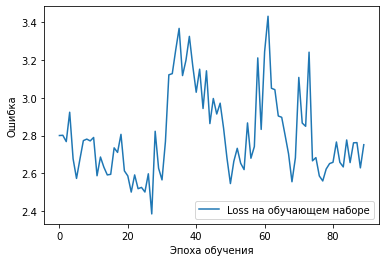

min: 2.3850011825561523
last: 2.751800537109375


In [ ]:
# Первые 100 эпох
loss1 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep0_100.csv')
values = loss1.values[:, 1]
plt.plot(values[10:100],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', values.min())
print ('last:', values[-1])

#### 200 эпох

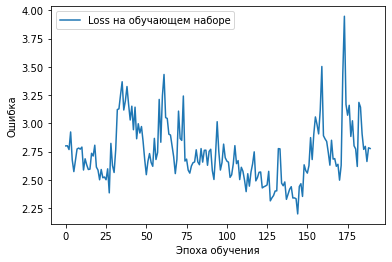

min: 2.1987175941467285
last: 2.777672529220581


In [ ]:
# 200 эпох
loss2 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.001__ep100_200.csv')
values2 = loss2.values[:, 1]
full_loss = np.concatenate((values, values2))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### 300 эпох

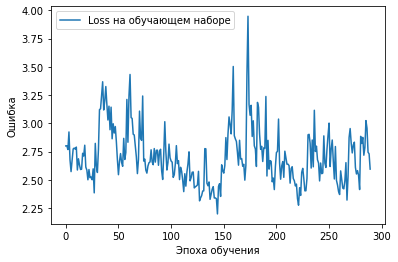

min: 2.1987175941467285
last: 2.5951380729675293


In [ ]:
# 300 эпох
loss3 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep0_100.csv')
values3 = loss3.values[:, 1]
full_loss = np.concatenate((full_loss, values3))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

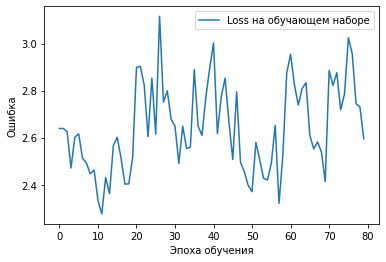

min: 2.1987175941467285


In [ ]:
plt.plot(full_loss[-80:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())

#### 400 эпох

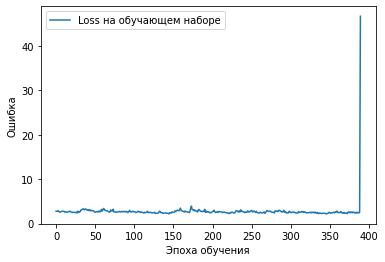

min: 2.193307399749756
last: 46.7202377319336


In [ ]:
# 400 эпох
loss4 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.0001__ep100_200.csv')
values4 = loss4.values[:, 1]
full_loss = np.concatenate((full_loss, values4))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

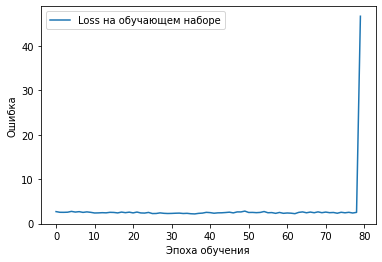

min: 2.193307399749756
last: 46.7202377319336


In [ ]:
plt.plot(full_loss[-80:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### 500 эпох

In [ ]:
# 500 эпох
loss5 = pd.read_csv(path+'csv/YOLO/loss__el1000_opt0.00001__ep0_100.csv')
values5 = loss5.values[:, 1]
full_loss = np.concatenate((full_loss, values5))
plt.plot(full_loss[10:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

In [ ]:
plt.plot(full_loss[-80:],
         label='Loss на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
print ('min:', full_loss.min())
print ('last:', full_loss[-1])

#### На тестовой выборке

In [ ]:
val_loss1 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep0_100.csv').values[:,1]
val_loss2 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.001__ep100_200.csv').values[:,1]
val_loss3 = pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep0_100.csv').values[:,1]
val_loss4= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.0001__ep100_200.csv').values[:,1]
#val_loss5= pd.read_csv(path+'csv/YOLO/valloss__el1000_opt0.00001__ep0_100.csv').values[:,1]
print ('Ошибки на последней эпохе каждого шага:')
print ('100 эпох:', str(round(val_loss1[-1], 4)))
print ('210 эпох:', str(round(val_loss2[-1], 4)))
print ('300 эпох:', str(round(val_loss3[-1], 4)))
print ('400 эпох:', str(round(val_loss4[-1], 4)))
#print ('500 эпох:', str(round(val_loss5[-1], 4)))

Ошибки на последней эпохе каждого шага:
100 эпох: 4.1225
210 эпох: 3.251
300 эпох: 3.4302
400 эпох: 40668.8516


# 5 Обнаружение объектов

In [ ]:
model_weight = path + 'weights/YOLOv3__el1000__opt0.00001__ep0_100.h5' # Указываем файл с весами модели
max_boxes = 5 # Максимальное количество ограничивающих рамок на изображении

In [ ]:
model_YOLO = create_YOLOv3(Input(shape=(416, 416, 3)), 9//3) # Создаем модель

In [ ]:
model_YOLO.load_weights(model_weight) # Загружаем посчитанные веса модели
print ('{} загружены.'.format(model_weight))

In [ ]:
# Создаем набор цветов для ограничивающих рамок
import colorsys
hsv_tuples = [(x / len(name_classes), 1., 1.) for x in range(len(name_classes))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x:(int(x[0]*255), int(x[1]*255), int(x[2]*255)), colors))
np.random.seed(43)
np.random.shuffle(colors)
np.random.seed(None)

In [ ]:
# Берем изображение из набора или с компьютера
#line = annotation['airplane_922'].split()
#image = Image.open(path_main_directory+line[0])
model_image_size = (416,416) # Задаем размер входных данных
image = Image.open(path+'test/plane3.jpg') # Загружаем изображение
plt.imshow (image) # Выводим изображение

In [ ]:
# Изменяем размер картинки под input_shape
iw, ih = image.size
w, h = (416, 416)
scale = min(w / iw, h / ih)
nw = int(iw * scale)
nh = int(ih * scale)
image_for_predict = image.resize((nw, nh), Image.BICUBIC)
new_image = Image.new('RGB', (416,416), (128, 128, 128))
new_image.paste(image_for_predict, ((w - nw) // 2, (h - nh) // 2))
image_for_predict = new_image
image_for_predict = np.array(image_for_predict) / 255.
plt.imshow(image_for_predict)
image_for_predict = image_for_predict.reshape(1, 416, 416, 3)
print (image_for_predict.shape)

In [ ]:
predict = model_YOLO.predict(image_for_predict)
num_layers = len(predict) # Получаем количество сеток
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] # Задаем маски для 3 уровней анкоров
input_shape = np.array(predict[0].shape[1:3]) * 32  # Получаем размер выходного изображения
image_shape = np.array([image.size[1], image.size[0]]) # Сохраняем размер оригинального изображения
print(input_shape)
print(image_shape)

In [ ]:
level_anchor = 0 # Укажем уровень сетки
num_anchors = len(anchors[anchor_mask[level_anchor]]) # Получаем количество анкоров
anchors_tensor = np.reshape(anchors[anchor_mask[level_anchor]], (1,1,1,num_anchors,2)) # Выбираем анкоры для нашего уровня сетки и решейпим
print(anchors_tensor.shape)
print(anchors_tensor)

In [ ]:
grid_shape = predict[level_anchor].shape[1:3] # Получим размерность сетки
grid = [] # Массив для финальной сетки
grid_row = [] # Массив для столбца
for i in range(grid_shape[0]): # По всем строкам
  for j in range(grid_shape[1]): # По всем столбцам
    grid_row.append([j , i]) # Создаем элемент [j, i]
  grid.append(grid_row) # Добавляем столбец в финальную сетку
  grid_row = [] # Обнуляем данные для столбца
grid = np.array(grid) # Переводим в numpy
grid = np.expand_dims(grid, axis=2) # Добавляем размерность
print(grid.shape) # Отборажаем размерность сетки

In [ ]:
# Решейпим предикт
feats = np.reshape(predict[level_anchor], (-1, grid_shape[0], grid_shape[1], num_anchors, num_classes+5))
print(feats.shape)
print (feats[0][6][7][1])

In [ ]:
print (feats[0][2][8][2])

In [ ]:
print (feats[0][2][2][2])

In [ ]:
# Функция расчета сигмоиды для вектора
def sigmoid(x): # На вход подаем массив данных
  return 1/(1+np.exp(-x)) # Возвращаем сигмоиду для всех элементов массива

In [ ]:
# Получаем параметры бокса

# Координаты центра bounding box
xy_param = feats[..., :2] # Выцепляем 0 и 1 параметры из предикта (соответствуют параметрам смещения центра анкора)
box_xy = (sigmoid(xy_param) + grid)/grid_shape[::-1] # Получаем координаты центра bounding box

# Высота и ширна bounding box
wh_param = feats[..., 2:4] # Выцепляем 2 и 3 параметры из предикта (соответствуют праметрам изменения высоты и ширины анкора)
box_wh = np.exp(wh_param) * anchors_tensor / input_shape[::-1] # Получаем высоту и ширину bounding box

# Вероятность наличия объекта в анкоре
conf_param = feats[..., 4:5] # Выцепляем 4 параметр из предикта (соответствуют вероятности обнаружения объекта)
box_confidence = sigmoid(conf_param) # Получаем вероятность наличия объекта в bounding box

# Класс объекта
class_param = feats[...,5:] # Выцепляем 5+ параметры из предикта (соответствуют вероятностям классов объектов)
box_class_probs = sigmoid(class_param) # Получаем вероятности классов объектов
print(box_xy.shape)
print(box_wh.shape)
print(box_confidence.shape)
print(box_class_probs.shape)
print(box_xy[0][6][7][1])
print(box_wh[0][6][7][1])
print(box_confidence[0][6][7][1])
print(box_class_probs[0][6][7][1])

In [ ]:
print(box_xy[0][2][2][2])
print(box_wh[0][2][2][2])
print(box_confidence[0][2][2][2])
print(box_class_probs[0][2][2][2])

In [ ]:
# Корректируем ограничивающие рамки (Размер изображения на выходе 416х416)
# И найденные параметры соответствуют именно этой размерности
# Необходимо найти координаты bounding box для рамерности исходного изображения
box_yx = box_xy[..., ::-1].copy()
box_hw = box_wh[..., ::-1].copy()

new_shape = np.round(image_shape * np.min(input_shape/image_shape)) # Находим размерность пропорциональную исходной с одной из сторон 416
offset = (input_shape-new_shape)/2./input_shape # Смотрим на сколько надо сместить в относительных координатах
scale = input_shape/new_shape  # Находим коэфициент масштабирования
box_yx = (box_yx - offset) * scale # Смещаем по координатам
box_hw *= scale # Масштабируем ширину и высоту

box_mins = box_yx - (box_hw / 2.) # Получаем левые верхние координаты (от середины отнимаем половину ширины и высоты)
box_maxes = box_yx + (box_hw / 2.) # Получаем правые нижнние координаты (к середине прибавляем половину ширины и высоты)
_boxes =  np.concatenate([
    box_mins[..., 0:1], # yMin
    box_mins[..., 1:2], # xMin
    box_maxes[..., 0:1], # yMax
    box_maxes[..., 1:2]  # xMax
], axis=-1)
print(new_shape)
print(offset)
print(scale)
print(_boxes.shape)
print()
print(_boxes[0][6][7][1])
print(image_shape)
_boxes *= np.concatenate([image_shape, image_shape]) # Переводим из относительных координат в абсолютные
print(_boxes[0][6][7][1])


In [ ]:
# Получаем выходные параметры
_boxes_reshape = np.reshape(_boxes, (-1, 4)) # Решейпим все боксы в один массив
_box_scores = box_confidence * box_class_probs # Получаем вероятность каждого класса (умноженную на веоятность наличия объекта)
_box_scores_reshape = np.reshape(_box_scores, (-1, num_classes)) # Решейпим в один массив
print(_boxes_reshape.shape)
print(_box_scores_reshape.shape)
print(_boxes_reshape[256])
print(_box_scores_reshape[256]) # Вероятность того, что объект 0-го класса

In [ ]:
mask = _box_scores_reshape >= 0.7 # Берем все объекты, обнаруженные с вероятностью больше 0.7
print(np.where(mask == True))

In [ ]:
_boxes_out = _boxes_reshape[mask[:,0]]
_scores_out = _box_scores_reshape[:, 0][mask[:,0]]
classes_out = np.ones_like(_scores_out,'int32') * 0
print(_boxes_out)
print(_scores_out)
print (classes_out)

In [ ]:
font = ImageFont.truetype(font=path + 'font.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
thickness = (image.size[0] + image.size[1]) // 300

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(classes_out))):
  print(c)
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = _boxes_out[i]
  score = _scores_out[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])

  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)

**Non-Maximum Suppression**

In [ ]:
def non_max_suppression_fast(boxes, scores, overlapThresh):
  if len(boxes) == 0: # Если нет ни одного бокса
    return []

  pick = [] # Индексы возвращаемых боксов

  x1 = boxes[:,0] # координаты x левыъ верхних углов
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(scores)

  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / area[idxs[:last]]
    idxs = np.delete(idxs, np.concatenate(([last],
                                           np.where(overlap > overlapThresh)[0])))

  return boxes[pick].astype("int"), scores[pick]

In [ ]:
new_boxes, new_scores = non_max_suppression_fast(_boxes_out, _scores_out, 0.15)
new_classes = np.ones_like(new_scores,'int32') * 0
print(new_boxes)

In [ ]:
image_pred = image.copy()
for i, c in reversed(list(enumerate(new_classes))):
  draw = ImageDraw.Draw(image_pred)
  predicted_class = name_classes[c]
  box = new_boxes[i]
  score = new_scores[i]

  label = '{} {:.2f}'.format(predicted_class, score)
  label_size = draw.textsize(label, font)

  top, left, bottom, right = box
  top = max(0, np.floor(top + 0.5).astype('int32'))
  left = max(0, np.floor(left + 0.5).astype('int32'))
  bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
  right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
  print(label, (left, top), (right, bottom))

  if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
  else:
      text_origin = np.array([left, top + 1])

  for i in range(thickness):
      draw.rectangle(
          [left + i, top + i, right - i, bottom - i],
          outline=colors[c])
  draw.rectangle(
      [tuple(text_origin), tuple(text_origin + label_size)],
      fill=colors[c])
  draw.text(text_origin, label, fill=(0, 0, 0), font=font)
  del draw
image_pred.save('new_image.jpg')
plt.imshow(image_pred)

In [ ]:
files.download('new_image.jpg')

# 6 Результаты

In [ ]:
results_0 = {'Количество пройденных эпох обучения': [100, 200, 300, 400, 500],
        'Шаг обучения': ['1e-3', '1e-3', '1e-4', '1e-4', '1e-5'],
        'Время обучения (сек., на 1 эпоху)': [120, 135, 121, 125, 123],
        'Значение ошибки': [5.2484, 5.4149, 2.8133, 2.5300, 2.5910]}

results_0_base = pd.DataFrame(results_0)

In [ ]:
results_1 = {'Количество пройденных эпох обучения': [100, 200, 300, 400, 500],
        'Шаг обучения': ['1e-3', '1e-3', '1e-4', '1e-4', '1e-5'],
        'Время обучения (сек., на 1 эпоху)': [10, 10, 9, 9, 9],
        'Значение ошибки': [3.3598, 3.4843, 2.9003, 3.7071, 2.5725]}

results_1_base = pd.DataFrame(results_1)

In [ ]:
print('Таблица 1 - Результаты обучения на большой выборке (981 объект)')
results_0_base.head()

Таблица 1 - Результаты обучения на большой выборке (981 объект)


,Количество пройденных эпох обучения,Шаг обучения,"Время обучения (сек., на 1 эпоху)",Значение ошибки
0,100,1e-3,120,5.2484
1,200,1e-3,135,5.4149
2,300,1e-4,121,2.8133
3,400,1e-4,125,2.5300
4,500,1e-5,123,2.5910


In [ ]:
print('Таблица 2 - Результаты обучения на уменьшенной выборке (74 объекта)')
results_1_base.head()

Таблица 2 - Результаты обучения на уменьшенной выборке (74 объекта)


,Количество пройденных эпох обучения,Шаг обучения,"Время обучения (сек., на 1 эпоху)",Значение ошибки
0,100,1e-3,10,3.3598
1,200,1e-3,10,3.4843
2,300,1e-4,9,2.9003
3,400,1e-4,9,3.7071
4,500,1e-5,9,2.5725


# 7 Выводы

Подготовлена и обучена свёрточная нейронная сеть (YOLO v3), предназначенная для обнаружения объектов.

Проверена гипотеза об уменьшении размера обучающей выборки (с 981 до 74 объектов).

К основным выводам можно отнести следующие:

  1) при уменьшении обучающей выборки скорость обучения значительно возрасла (со 135 до 10 секунд на эпоху);

  2)  не смотря на значительное уменьшение обучающей выборки, значение ошибки, в целом, снизилось, либо осталось на том же уровне (в пределах погрешности измерений);

  3) представляется более эффективным обучение с меньшим количеством эпох для каждого шага обучения (например, по 100 эпох для каждого шага).

  К недостаткам проведённой рабоnы можно отнести следующее:
  - не сформирована функция этапов распознования изображения;
  - не удалось сохранить веса после обучения с шагом 1e-5 и, как следствие, отобразить график обучения и наглядные результаты распознования объектов.